In [1]:
# Core python libraries
import csv
import re
import math
import os
import time

# External libraries.
import nltk
import numpy
import pandas
import scipy
import sklearn
import tempfile

# Tensorflow and related.
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt

# For dynamically reolading modules. imp.reload(module_name) 
import imp

# Internal libraries
import tf_utils

# So you know when this code block finishes.
print ("Done")

Done


In [2]:
#TODO(Max): make a library that does all this preprocessing
data = pandas.read_csv("data/train.csv") # Can read a subset. First nrows of the total.
LABEL_COLUMN = "SalaryNormalized"

TEST_SIZE = .2

print(len(data))

195971


In [3]:
# sklearn.cross_validation has been replaced with model_selection.
X_train_index, X_test_index, Y_train, Y_test = sklearn.model_selection.train_test_split(
    data.index, data[LABEL_COLUMN], test_size=TEST_SIZE, random_state=42)

# Keep train and test as pandas dataframes.
X_train = data.iloc[X_train_index]
X_test = data.iloc[X_test_index]

y_train = numpy.array(X_train[LABEL_COLUMN].astype(numpy.float32))
y_test = numpy.array(X_test[LABEL_COLUMN].astype(numpy.float32))

print ("Done")

Done


In [4]:
print(y_train.mean())

34127.2


In [5]:
# Normalizing input values to mean 0, standard deviation 1.
train_mean, train_std = y_train.mean(), y_train.std()

# Normalize input labels and expectations
y_train = tf_utils.normalize_input(y_train, train_mean, train_std)
y_test = tf_utils.normalize_input(y_test, train_mean, train_std)


In [7]:
#imp.reload(tf_utils) 

min_word_frequency = 30

tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    min_df=min_word_frequency, decode_error='ignore', tokenizer=tf_utils.PorterTokenizer())

# Transform BOW test set.
# Transform title, full description, raw location

def process_text_column(train_dataframe, test_dataframe, colname, vectorizer):
    print("Starting to process \"%s\" text column." % colname)
    train_output = vectorizer.fit_transform(train_dataframe[colname])
    test_output = vectorizer.transform(test_dataframe[colname])
    print("\"%s\" number of columns = %d" % (colname, train_output.shape[1]))
    return (train_output, test_output)

# Text columns:
title_train, title_test = process_text_column(X_train, X_test, "Title", tfidf_vectorizer)

location_raw_train, location_raw_test = process_text_column(X_train, X_test, "LocationRaw", tfidf_vectorizer)

# This one takes a while: Pickle this bugger.
print("Processing the \"FullDescription\" field will take a while")
full_description_train, full_description_test = process_text_column(
    X_train, X_test, "FullDescription", tfidf_vectorizer)


# Categorical columns: (category, contract, and source, were represented using a 1-of-K encoding.)
"""
def process_categorical_column(train_dataframe, test_dataframe, colname, label_encoder, one_hot_encoder):
    print("Starting to process \"%s\" categorical column." % colname)
    train_output_labels = label_encoder.fit_transform(train_dataframe[colname].values.reshape(-1, 1))
    train_output_values = one_hot_encoder.fit_transform(train_output_labels)

    test_output_labels = label_encoder.transform(test_dataframe[colname].values.reshape(-1, 1))
    test_output_values = one_hot_encoder.transform(test_output_labels)

    print("\"%s\" number of columns = %d" % (colname, train_output_values.shape[1]))
    return (train_output_values, test_output_values)

def process_categorical_column_dict(train_dataframe, test_dataframe, colname, dict_vectorizer):
    print("Starting to process \"%s\" categorical column." % colname)
    train_data = train_dataframe[colname].values()
    train_output_values = dict_vectorizer.fit_transform(train_data.to_dict())

    test_output_values = dict_vectorizer.transform(test_dataframe[colname].to_dict())
    #print(train_data)

    print(train_output_values)
    print("\"%s\" number of columns = %d" % (colname, train_output_values.shape[0]))
    return (train_output_values, test_output_values)
"""


# label_encoder = sklearn.preprocessing.LabelEncoder()
# one_hot_encoder = sklearn.preprocessing.OneHotEncoder()
# dict_vectorizer = sklearn.feature_extraction.DictVectorizer()

#category_train, category_test = process_categorical_column_dict(X_train, X_test, "Category", dict_vectorizer)

cols_to_transform = ['Category', 'ContractType', 'ContractTime', 'SourceName']
sparse_df = pandas.get_dummies(data=data[cols_to_transform], columns = cols_to_transform , prefix=cols_to_transform, sparse=True)
sparse_df_train = sparse_df.iloc[X_train_index]
sparse_df_test = sparse_df.iloc[X_test_index]

categorical_columns_sparse_matrix_train = scipy.sparse.csr_matrix(sparse_df_train)
categorical_columns_sparse_matrix_test = scipy.sparse.csr_matrix(sparse_df_test)

#print(sparse_df_train.columns.values)
print(categorical_columns_sparse_matrix_train.shape)
print(categorical_columns_sparse_matrix_test.shape)
"""
category_train, category_test = process_categorical_column(X_train, X_test, "Category", label_encoder, one_hot_encoder)
contract_type_train, contract_type_test = process_categorical_column(X_train, X_test, "ContractType", label_encoder, one_hot_encoder)
contract_time_train, contract_time_test = process_categorical_column(X_train, X_test, "ContractTime", label_encoder, one_hot_encoder)
source_train, source_test = process_categorical_column(X_train, X_test, "SourceName", label_encoder, one_hot_encoder)
"""
# Why not company?

Starting to process "Title" text column.
"Title" number of columns = 1638
Starting to process "LocationRaw" text column.
"LocationRaw" number of columns = 657
Starting to process "FullDescription" text column.
"FullDescription" number of columns = 10708
(156776, 202)
(39195, 202)


NameError: name 'x_train' is not defined

In [8]:
# Stack all the sparse datasets.

# Unsure if I need this one.
normalizer = sklearn.preprocessing.Normalizer()

x_train = normalizer.fit_transform(scipy.sparse.csr_matrix(scipy.sparse.hstack(
    [title_train, location_raw_train, full_description_train, categorical_columns_sparse_matrix_train])
                                  ))
x_test = normalizer.transform(scipy.sparse.csr_matrix(scipy.sparse.hstack(
    [title_test, location_raw_test, full_description_test, categorical_columns_sparse_matrix_test])
))
print("x_train shape: %s, %s" % x_train.shape)
print("x_test shape: %s, %s" % x_test.shape)

# Need this for my batch code below
assert type(x_train) == scipy.sparse.csr_matrix
assert type(x_test)== scipy.sparse.csr_matrix

x_train shape: 156776, 13205
x_test shape: 39195, 13205


In [67]:
# Define data nput functions. These have to be done here as the 
# functions take no arguments. Also the dict labels are specific to 
# the model.
#TODO(buckleym): Remove
DIMENSIONS = x_train.shape[1]

def input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_batches, DIMENSIONS, x_train, y_train):
        yield {input_data: batch_input, input_target: batch_labels}

def eval_input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_validation_batches, DIMENSIONS, x_test, y_test):
        yield {input_data: batch_input, input_target: batch_labels}


In [68]:
imp.reload(tf_utils)

for data in input_fn(): 
    x  = data[input_data]
    y = data[input_target]
    print(x.sum(axis=1))
    print(y)
    break
    
print(x_train.sum(axis=0))

[ 6.43790436  6.58651161  5.00735569 ...,  5.81052828  7.13706541
  6.50317097]
[[ 0.75887769]
 [ 0.81562567]
 [-0.60307348]
 ..., 
 [-0.23421171]
 [ 0.04952811]
 [-0.62917757]]
[ 6.57601547  6.98619747  6.30404997 ...,  4.33312035  6.56132126
  6.5522871 ]
[[-0.61743069]
 [ 0.61700779]
 [ 0.47513786]
 ..., 
 [-1.06500196]
 [ 0.9007476 ]
 [-0.31933364]]
[ 6.91561222  5.30412483  7.07416344 ...,  6.55507898  5.84962034
  5.64246273]
[[ 0.64538175]
 [-1.06500196]
 [-0.98328483]
 ..., 
 [-0.51795155]
 [ 0.61700779]
 [-1.07124424]]
[ 5.35458374  6.7734499   6.34373379 ...,  6.94630337  6.95247841
  6.73056746]
[[ 0.61700779]
 [ 0.58863378]
 [-0.37608162]
 ..., 
 [-0.65982145]
 [ 0.61700779]
 [ 2.17757678]]
[ 4.98694992  5.62952328  5.39273548 ...,  6.12389469  5.26557875
  5.74443531]
[[ 0.04952811]
 [ 2.48969054]
 [-0.46120358]
 ..., 
 [-1.3678658 ]
 [-0.63144743]
 [ 1.18448746]]
[ 6.63537216  6.94374275  5.99561596 ...,  6.84712124  6.16429138
  6.33982944]
[[-0.80169135]
 [-0.4044556 ]


KeyboardInterrupt: 

In [69]:
# Define model

graph = tf.Graph()

sess = tf.Session(graph=graph)

learning_rate = .01

l1_regularization_coef = 0.0 #1
l2_regularization_coef = 0.0 #1

# Implement this by batch.
batch_size = 512

#(32,16,8) worked well
# (1024, 256, 64) Doesn't work
# (128, 32, 8) Neither
FIRST_LAYER_SIZE = 32
SECOND_LAYER_SIZE = 16
THIRD_LAYER_SIZE = 8

# Given small layers probably need this a little higher.
DROPOUT_KEEP_PROBABILITY = 1.0

with graph.as_default():

    with tf.name_scope("input_data"):
        # Initialize data placeholders
        input_data = tf.placeholder(shape=[batch_size, DIMENSIONS], dtype=tf.float32)
        input_target = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name="labels")

    with tf.device('/gpu:0'):

        with tf.name_scope("first_hidden_layer"):
            first_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[DIMENSIONS, FIRST_LAYER_SIZE], minval=-1, maxval=1))
            first_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            first_layer_product = tf.matmul(input_data, first_layer_hidden_units)
            first_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(first_layer_product, first_layer_bias)), DROPOUT_KEEP_PROBABILITY)
            
        with tf.name_scope("second_hidden_layer"):
            second_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[FIRST_LAYER_SIZE, SECOND_LAYER_SIZE], minval=-1, maxval=1))
            second_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            second_layer_product = tf.matmul(first_layer_output, second_layer_hidden_units)
            second_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(second_layer_product, second_layer_bias)), DROPOUT_KEEP_PROBABILITY)
            
        with tf.name_scope("third_hidden_layer"):
            third_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[SECOND_LAYER_SIZE, THIRD_LAYER_SIZE], minval=-1, maxval=1))
            third_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            third_layer_product = tf.matmul(second_layer_output, third_layer_hidden_units)
            third_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(third_layer_product, third_layer_bias)), DROPOUT_KEEP_PROBABILITY)

        with tf.name_scope("output_layer"):
            output_layer_coefficients = tf.Variable(tf.random_uniform(shape=[THIRD_LAYER_SIZE, 1], minval=-1, maxval=1))
            output_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            output_layer_product = tf.matmul(third_layer_output, output_layer_coefficients)
            model_output = tf.add(output_layer_product, output_layer_bias, name="predictions")

    with tf.name_scope("loss"):
        # Mean Absolute Error.
        mae = tf.reduce_mean(tf.abs(tf.subtract(input_target, model_output)))
        
        loss = mae

        # If we are using regularization.
        if l1_regularization_coef > 0 or l2_regularization_coef > 0:
            l1_regularizer = tf.contrib.layers.l1_regularizer(scale=l1_regularization_coef)
            l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_regularization_coef)

            weights = tf.trainable_variables() # all vars of your graph
            regularization_penalty = tf.add(tf.contrib.layers.apply_regularization(l1_regularizer, weights),
                                             tf.contrib.layers.apply_regularization(l2_regularizer, weights))
            loss = loss + regularization_penalty # this loss needs to be minimized

    with tf.name_scope("reporting"):
        # Converts back to original, salary scale.
        error_salary_scale = tf.reduce_mean(tf.abs(tf.multiply(mae, train_std))

        # Log for tensorboard
        training_summary = tf.summary.scalar('train_loss', loss)
        validation_summary = tf.summary.scalar('validation_loss', loss)
        # Add mean absolute errors.
        training_mae = tf.summary.scalar('train_mae', mean_absolute_error_salary_scale)
        validation_mae = tf.summary.scalar('validation_mae', mean_absolute_error_salary_scale)

    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Declare optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    # This one seems to work better :D
    train_op = tf.contrib.layers.optimize_loss(      
     loss, tf.contrib.framework.get_global_step(),      
     optimizer='Adam'
        , learning_rate=learning_rate)


In [62]:
# Number of
number_of_epochs = 1000
batches_per_epoch = x_train.shape[0]/batch_size
number_of_batches = math.ceil(x_train.shape[0]/batch_size)
number_of_validation_batches = number_of_batches

logs_dir = "logs/neuralnetkaggleinspired"

checkpoint_frequency = 250

reporting_frequency = 1

total_loss = 0
validation_loss = 0
validation_batch_average_window = 100

ckpt = None
#ckpt = tf.train.get_checkpoint_state(logs_dir)  

In [ ]:
# Where to save this model.
model_path = os.path.join(logs_dir, time.strftime("%Y-%m-%d-%H-%M-%S"))

if ckpt:
    restore_from_model = True
    print("Restore from model!")
else:
    restore_from_model = False

with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    summaries = tf.summary.merge_all()                                                       
    writer = tf.summary.FileWriter(model_path,
        graph=session.graph)                  

    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    
    if restore_from_model:
        saver.restore(session, ckpt.model_checkpoint_path)
        
    global_step = 0
        
    for epoch in range(number_of_epochs):
        eval_feed_generator = eval_input_fn()
        # Shuffle the training input
        x_train, y_train = tf_utils.unison_shuffled_copies(x_train, y_train)

        for step, feed_dict in enumerate(input_fn()):
            global_step += 1
            start_time = time.time()

            _, temp_loss = session.run([train_op, loss], feed_dict=feed_dict)
            
            duration = time.time() - start_time
            
            if global_step % reporting_frequency == 0:
                print("Epoch: %s Iteration: %s : Loss: %.4f (%.3f sec)" % 
                      (epoch, (step + 1), temp_loss, duration))

                train_summ, train_mae = session.run([training_summary, training_mae], feed_dict=feed_dict)
                writer.add_summary(train_summ, global_step)
                writer.add_summary(train_mae, global_step)
                _, valid_summ, valid_mae = session.run(
                        [loss, validation_summary, validation_mae],
                        feed_dict=next(eval_feed_generator))
                writer.add_summary(valid_summ, global_step)
                writer.add_summary(valid_mae, global_step)

                writer.flush()                

            if (global_step % checkpoint_frequency == 0) or (global_step == number_of_batches):
                print("Saving at epoch %s step: %s" % (epoch, step + 1))
                saver.save(session, model_path, global_step=tf.contrib.framework.get_global_step())

Epoch: 0 Iteration: 1 : Loss: 6.3562 (0.020 sec)
Epoch: 0 Iteration: 2 : Loss: 3.5781 (0.012 sec)
Epoch: 0 Iteration: 3 : Loss: 1.8872 (0.013 sec)
Epoch: 0 Iteration: 4 : Loss: 1.5360 (0.012 sec)
Epoch: 0 Iteration: 5 : Loss: 1.3670 (0.014 sec)
Epoch: 0 Iteration: 6 : Loss: 1.2333 (0.015 sec)
Epoch: 0 Iteration: 7 : Loss: 1.1993 (0.011 sec)
Epoch: 0 Iteration: 8 : Loss: 1.0588 (0.016 sec)
Epoch: 0 Iteration: 9 : Loss: 0.9319 (0.012 sec)
Epoch: 0 Iteration: 10 : Loss: 0.8961 (0.013 sec)
Epoch: 0 Iteration: 11 : Loss: 0.9378 (0.012 sec)
Epoch: 0 Iteration: 12 : Loss: 0.8764 (0.016 sec)
Epoch: 0 Iteration: 13 : Loss: 0.8621 (0.014 sec)
Epoch: 0 Iteration: 14 : Loss: 0.8936 (0.015 sec)
Epoch: 0 Iteration: 15 : Loss: 0.8055 (0.012 sec)
Epoch: 0 Iteration: 16 : Loss: 0.8077 (0.013 sec)
Epoch: 0 Iteration: 17 : Loss: 0.8108 (0.017 sec)
Epoch: 0 Iteration: 18 : Loss: 0.8528 (0.014 sec)
Epoch: 0 Iteration: 19 : Loss: 0.8614 (0.016 sec)
Epoch: 0 Iteration: 20 : Loss: 0.8248 (0.012 sec)
Epoch: 0 

In [49]:
# Model Evaluation
# number_of_validation_batches is used above in the eval_input_fn
number_of_validation_batches = math.floor(len(x_test_text)/batch_size)
# Load checkpointed model.
ckpt = tf.train.get_checkpoint_state(logs_dir)                                     

# Write TF Model Evaluation Code here. 
with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    
    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    saver.restore(session, ckpt.model_checkpoint_path)
    prediction_array_list = []

    total_loss = 0
    for step, eval_feed_dict in enumerate(eval_input_fn()):    
        valid_loss, mae, model_predictions = session.run(
            [loss, mean_absolute_error_salary_scale, model_output], feed_dict=eval_feed_dict)
        #print("Batch: %d Mean: %.4f" % (step, mae))
        total_loss += mae
        prediction_array_list.append(model_predictions)
    print ("Mean Absolute Error Loss over all %s observations = %s" % ((step + 1) * batch_size, total_loss / (step + 1)))

INFO:tensorflow:Restoring parameters from logs/neuralnetbagofwords/2017-06-28-21-25-42-5750
Mean Absolute Error Loss over all 51200 observations = 6890.73701172


In [50]:
def flatten_predictions(predictions):
    return numpy.concatenate(predictions)

predictions = flatten_predictions(prediction_array_list)

n_predictions = predictions.shape[0]

actuals = y_test[0:n_predictions]

print(n_predictions, actuals.shape)
print(y_test)

51200 (51200,)
[ 0.89645004 -0.66550416  3.22435188 ..., -0.29010177  0.89645004
  0.95295256]


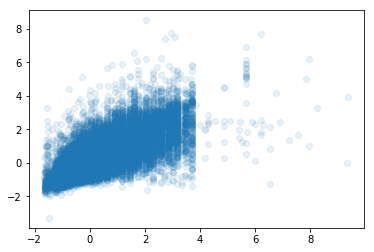

[[-1.2662046  -2.82815886  1.06169724 ...,  0.65487933 -2.19849539
  -2.53751016]
 [ 2.22026563  0.65831143  4.54816723 ...,  4.14134979  1.28797495
   0.94896007]
 [-4.18580246 -5.74775648 -1.85790062 ..., -2.26471853 -5.11809301
  -5.45710802]
 ..., 
 [-1.50738144 -3.0693357   0.8205204  ...,  0.41370249 -2.43967223
  -2.778687  ]
 [ 0.8513     -0.7106542   3.17920184 ...,  2.77238393 -0.0809907
  -0.42000553]
 [ 1.43651092 -0.12544328  3.76441288 ...,  3.35759497  0.50422019
   0.16520539]]


In [51]:
%matplotlib inline

def print_results(x_vals, y_vals):

    plt.scatter(x_vals, y_vals, alpha=.1)
    plt.show()

    print(x_vals-y_vals)
    #print(sorted([set(y_vals)]))

print_results(actuals, predictions)